In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential

In [ ]:
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [ ]:
from keras.callbacks import TensorBoard

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
#create a CNN
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = tf.keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [ ]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
#Training Set
train_set = train_datagen.flow_from_directory('/content/train',
                                             target_size=(64,64),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory('/content/test',
                                           target_size=(64,64),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set /no output available

test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/test1',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
classifier.fit_generator(train_set,
                        steps_per_epoch=800,
                        epochs = 200,
                        validation_data = test_set,
                        validation_steps = 20,
                        #callbacks=[tensorboard]
                        )


Epoch 1/200
625/800 [======================>.......] - ETA: 15s - loss: 0.6137 - accuracy: 0.6556

800/800 [==============================] - 56s 69ms/step - loss: 0.6137 - accuracy: 0.6556 - val_loss: 0.4554 - val_accuracy: 0.8031


In [ ]:
partial = 'partial.h5'
classifier.save(partial)

In [ ]:
classifier.save('/content/resources/partial.h5')

In [ ]:
from tensorflow.keras.models import load_model
classifier = load_model('resources/dogcat_model_bak.h5')

1/1 [==============================] - 0s 214ms/step


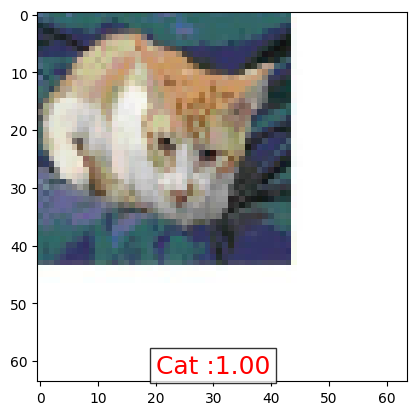

In [ ]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/test/cats/cat.10033.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Dog :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Cat :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

In [ ]:
import pandas as pd
test_set.reset
ytesthat = classifier.predict_generator(test_set)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

,filename,predict,y,y_pred
0,cats/cat.10.jpg,0.00000,0,0
1,cats/cat.10000.jpg,0.00000,0,0
2,cats/cat.10001.jpg,0.00000,0,0
3,cats/cat.10007.jpg,0.05543,0,0
4,cats/cat.10017.jpg,0.00000,0,0
5,cats/cat.10021.jpg,0.00000,0,0
6,cats/cat.10026.jpg,0.02022,0,0
7,cats/cat.10030.jpg,0.00121,0,0
8,cats/cat.10033.jpg,0.00000,0,0
9,cats/cat.10035.jpg,0.00000,0,0


In [ ]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 54


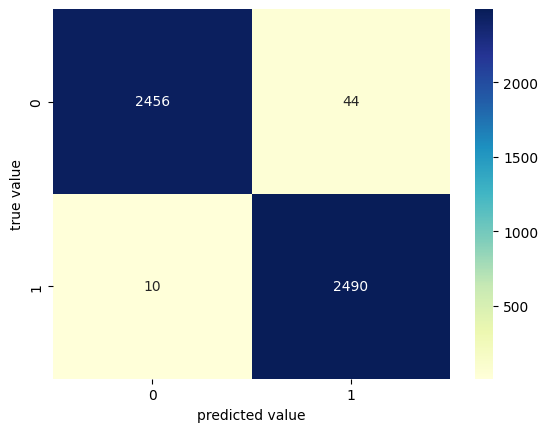

In [ ]:
#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

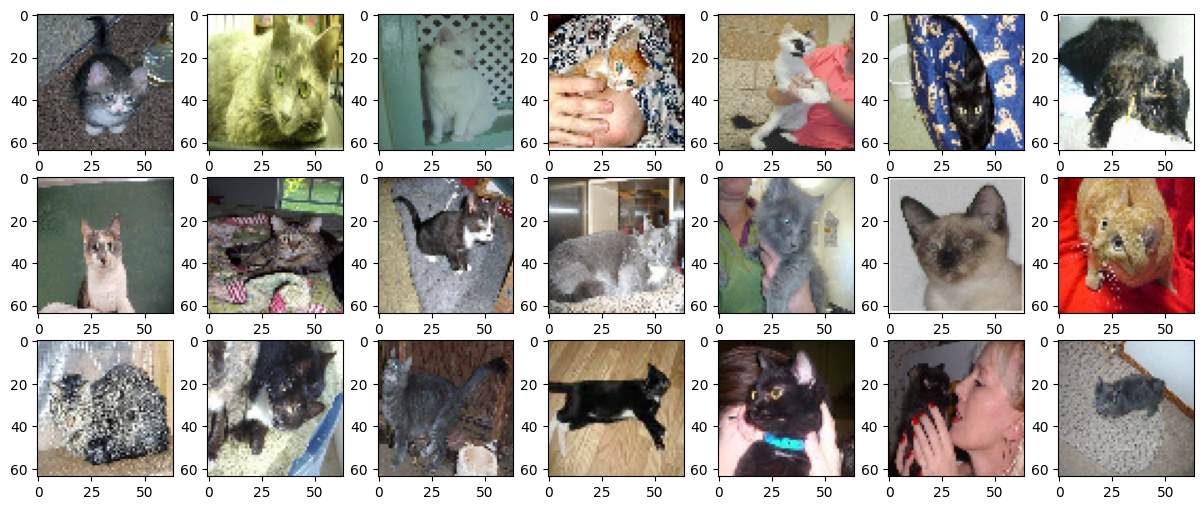

In [ ]:
#Some of Cat image misclassified as Dog.
import matplotlib.image as mpimg

CatasDog = df['filename'][(df.y==0)&(df.y_pred==1)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('test/'+CatasDog.iloc[i], target_size=(64, 64))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

plt.show()


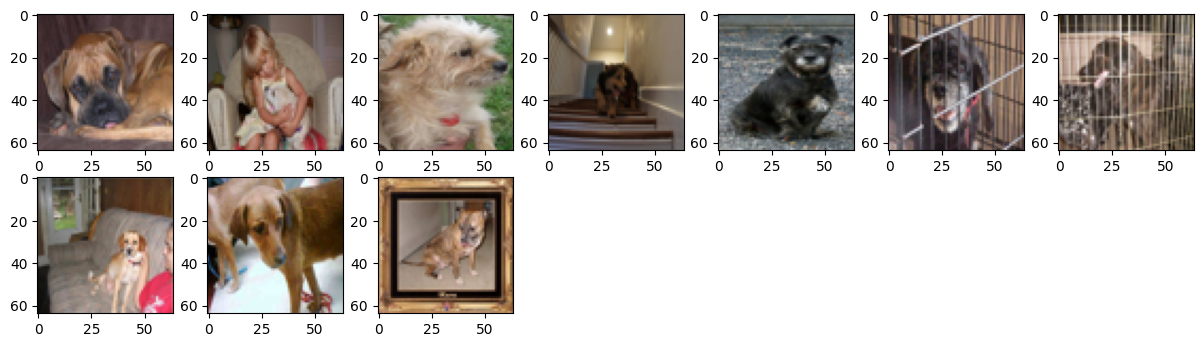

In [ ]:
#Some of Dog image misclassified as Cat.
import matplotlib.pyplot as plt
from PIL import Image

DogasCat = df['filename'][(df.y==1)&(df.y_pred==0)]
fig=plt.figure(figsize=(15, 6))
columns=7
rows=3
for i in range(len(DogasCat)):
    img = Image.open('test/'+DogasCat.iloc[i])
    img = img.resize((64, 64))
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()


In [ ]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

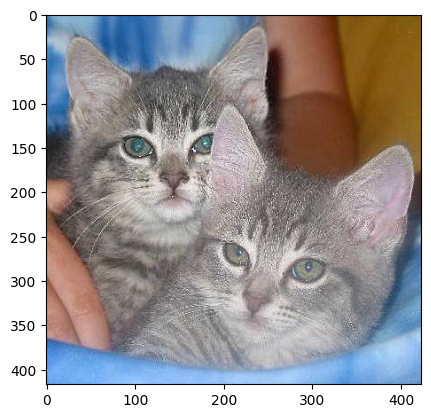

In [ ]:
### Visualization of Layers Ouptut
#Input Image for Layer visualization
img1 = image.load_img('/content/test/cats/cat.10021.jpg')
plt.imshow(img1);
#preprocess image
img1 = image.load_img('/content/test/cats/cat.10021.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [ ]:
model_layers = [ layer.name for layer in classifier.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d_6', 'max_pooling2d_6', 'conv2d_7', 'max_pooling2d_7', 'flatten_3', 'dense_6', 'dense_7']


In [ ]:
from tensorflow.keras.models import Model
conv2d_6_output = Model(inputs=classifier.input, outputs=classifier.get_layer('conv2d_6').output)
conv2d_7_output = Model(inputs=classifier.input,outputs=classifier.get_layer('conv2d_7').output)

In [ ]:
conv2d_6_features = conv2d_6_output.predict(img)
conv2d_7_features = conv2d_7_output.predict(img)
print('First conv layer feature output shape : ',conv2d_6_features.shape)
print('First conv layer feature output shape : ',conv2d_7_features.shape)

1/1 [==============================] - 0s 129ms/step
First conv layer feature output shape :  (1, 62, 62, 32)
First conv layer feature output shape :  (1, 29, 29, 32)


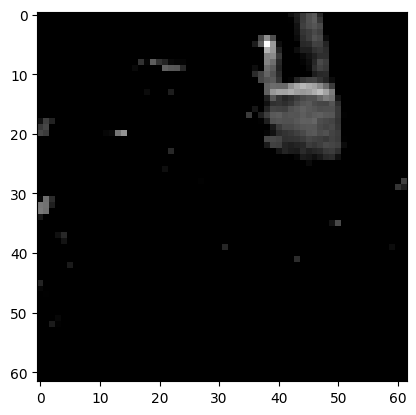

In [ ]:
plt.imshow(conv2d_6_features[0, :, :, 4], cmap='gray')

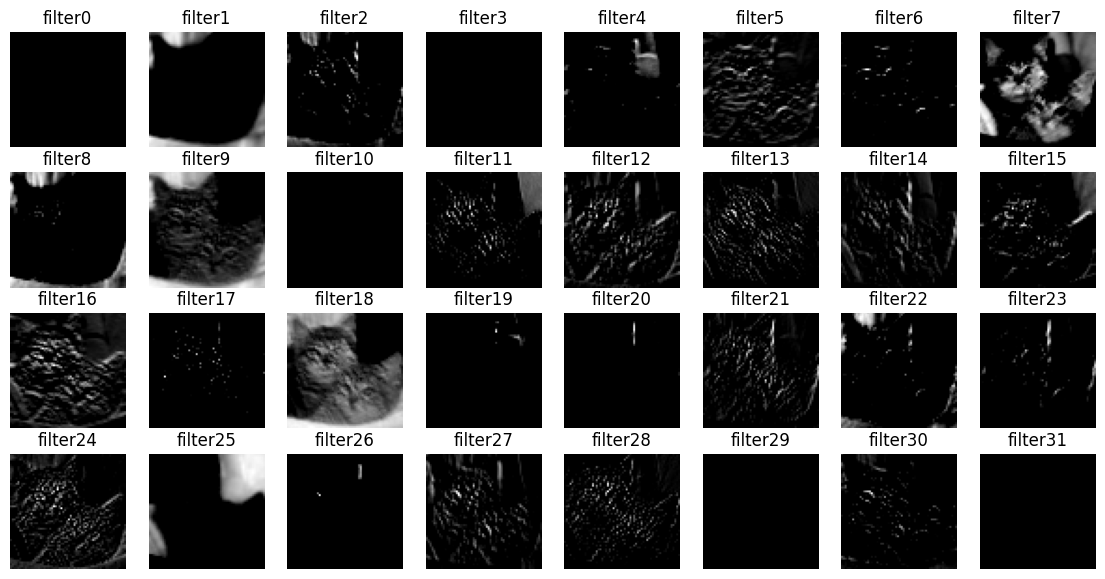

In [ ]:
#First cnn output
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_6_features[0, :, :, i], cmap='gray')
plt.show()

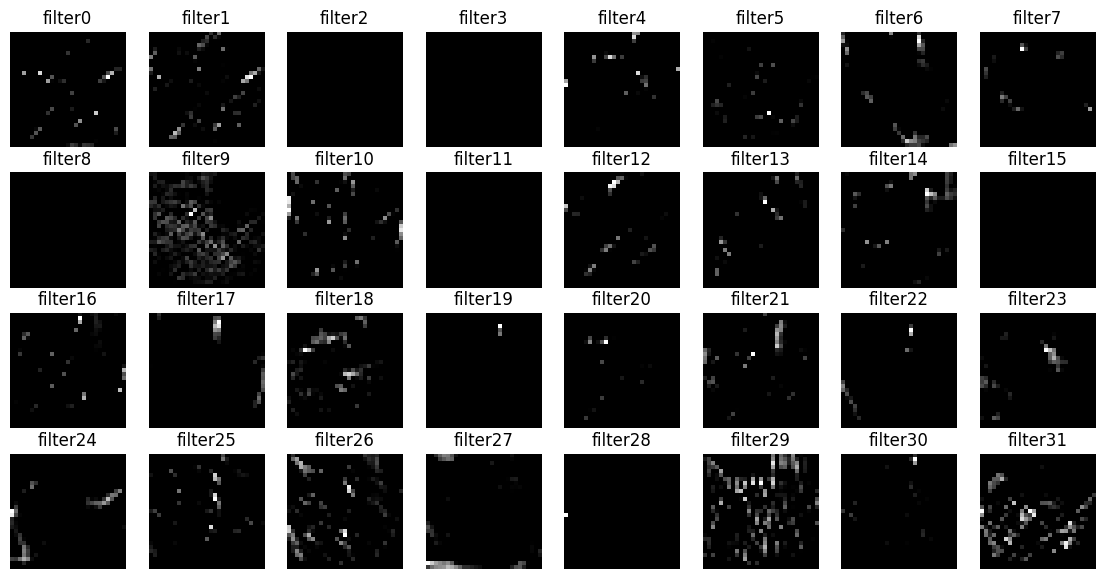

In [ ]:
#second cnn output
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_7_features[0, :, :, i], cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
#Test Set /no output available

test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/test1',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)


Found 373 images belonging to 1 classes.


1/1 [==============================] - 0s 16ms/step


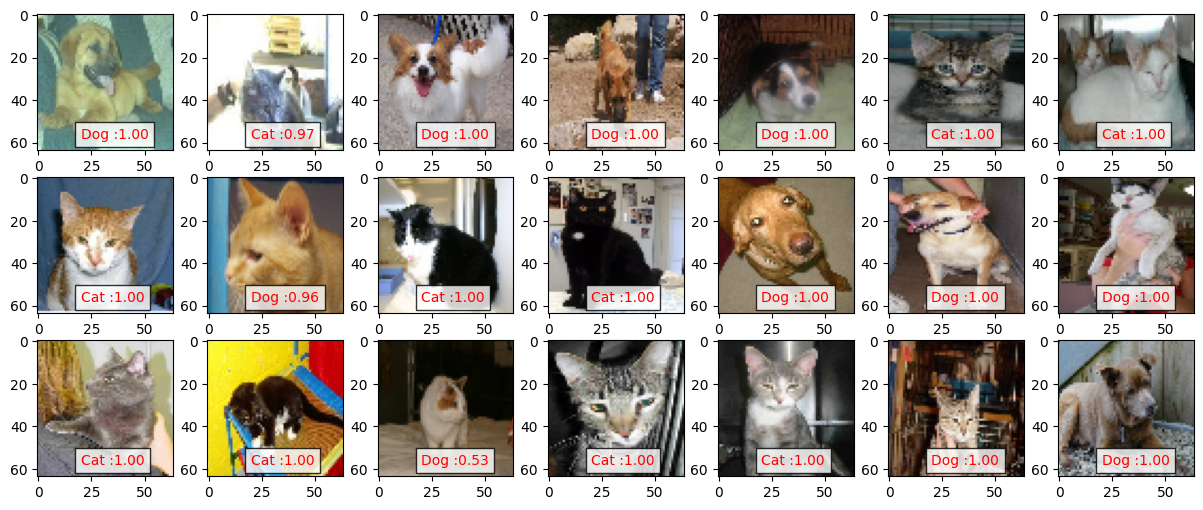

In [ ]:
### Model Performance on Unseen Data
# for generator image set u can use
# ypred = classifier.predict_generator(test_set)

fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img('/content/drive/MyDrive/test1/'+test_set1.filenames[np.random.choice(range(370))], target_size=(64, 64))
    img = image.img_to_array(img1)
    img = img/255
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='Dog :%1.2f'%(prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='Cat :%1.2f'%(1.0-prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)

In [ ]:
%%capture
# Model Accuracy
x1 = classifier.evaluate_generator(train_set)
x2 = classifier.evaluate_generator(test_set)

In [ ]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

Training Accuracy  : 99.41%     Training loss  : 0.024681
Validation Accuracy: 98.92%     Validation loss: 0.035291
